# EDA and Cleaning

## Contents
-  [Digital Nomad Data Import and Cleaning](#Digital-Nomad-Data-Import-and-Cleaning)
-  [Solo Travel Data Import and Cleaning](#Solo-Travel-Data-Import-and-Cleaning)
-  [Combine Digital Nomad and Solo Travel](#Combine-Digital-Nomad-and-Solo-Travel)
-  [Clean Combined Text](#Clean-Combined-Text)
-  [Data Visualization](#Data-Visualization)
    -  [Word and Character Count](#Word-and-Character-Count)
    -  [Most Common Words](#Most-Common-Words)
-  [Save as CSV](#Save-as-CSV)

In [1]:
import pandas as pd
import numpy as np
import json
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import stop_words

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
np.random.seed(44)
%matplotlib inline

## Digital Nomad Data Import and Cleaning

### Import Data

The data collected from r/digitalnomad is read in and assigned to an appropriately named panda dataframe, `dn_posts`.

In [2]:
with open('../data/dn_posts_1545275192.json', 'r') as f:
    dn_posts = json.load(f)

### Create DataFrame

`dn_posts` is a list of lists. Each list contains a dictionary with information we want to look at:
-  `created_utc`: epoch time of post as an integer
-  `selftext`: body of post
-  `title`: title of post
-  `url`: location/direct link to post
-  `created`: epoch time of post as a float

In [3]:
dn_posts[0][5].keys()

dict_keys(['created_utc', 'selftext', 'title', 'url', 'created'])

Lists that don't contain `selftext` will have a length less than 6. We will remove these posts entirely in order to key into each dictionary and put the remaining data in a dataframe.

In [4]:
def no_selftext(posts):
    for i in range(len(posts)):
        try:
            if len(posts[i]) != 6:
                del posts[i]
        except:
            pass
    return posts

In [5]:
dn_posts = no_selftext(dn_posts)

In [6]:
len(dn_posts)

5694

After removing the 11 posts with no `selftext`, we have 5,694 posts. 

We create a `dn_df` dataframe with `title` and `selftext`. We do not need `created_utc`, `url` and `created` to build our model so they are excluded from the dataframe.

In [7]:
dn_df = pd.DataFrame(data=[i[5] for i in dn_posts], columns=['title', 'selftext'])

In [8]:
dn_df.head()

,title,selftext
0,Where to spend the next month in the USA -,I need to burn a month until mid-January. I ca...
1,Apologies if this is old news,https://tulsaremote.com/
2,Where to look for cheap flights around Europe?,I've always heard of people getting £10 flight...
3,Social media training,Hi all! I am a digital marketing professional ...
4,Suggestions for place to live in US? (Preferab...,I'm starting my first remote job in January an...


### Remove Duplicates

We want to remove any duplicates that may have been collected before modeling.

In [9]:
dn_df.drop_duplicates(inplace=True)

In [10]:
len(dn_df)

5647

After dropping duplicates, there's a total of 5,647 posts (47 less).

### Missing Values

In [11]:
dn_df.isna().sum()

title       0
selftext    0
dtype: int64

There are no missing values in either `title` or `selftext`.

Some posts will indicate 
-  `[removed]`: the subreddit's moderator found the post to be either irrelevant to the community or a violation of its rules.
-  `[deleted]`: the user removed his/her own post.

We do not want to include these posts because the content will not contribute to our model if they don't align with the characteristics normally found in this community.

In [12]:
dn_df = dn_df[(dn_df['selftext'] != '[removed]') & 
              (dn_df['title'] != '[removed]') &
              (dn_df['selftext'] != '[deleted]')]

In [13]:
len(dn_df)

5122

After removing texts with `[removed]` and `[deleted]`, we're left with 5,122 posts.

### Combine `title` and `selftext`

Since `title` and `selftext` is one post, we want to create a new column, `text`, that's a combination of the two. We will use this column when preprocessing and modeling moving forward. We also create a `digital_nomad` column and input `1` to indicate the data falls in our positive class (category that we're interested in).

In [14]:
dn_df['text'] = dn_df['title'] + ' ' + dn_df['selftext']

In [15]:
dn_df['digital_nomad'] = 1

In [16]:
dn_df.reset_index(drop=True, inplace=True)

In [17]:
dn_df.head()

,title,selftext,text,digital_nomad
0,Where to spend the next month in the USA -,I need to burn a month until mid-January. I ca...,Where to spend the next month in the USA - I n...,1
1,Apologies if this is old news,https://tulsaremote.com/,Apologies if this is old news https://tulsarem...,1
2,Where to look for cheap flights around Europe?,I've always heard of people getting £10 flight...,Where to look for cheap flights around Europe?...,1
3,Social media training,Hi all! I am a digital marketing professional ...,Social media training Hi all! I am a digital m...,1
4,Suggestions for place to live in US? (Preferab...,I'm starting my first remote job in January an...,Suggestions for place to live in US? (Preferab...,1


## Solo Travel Data Import and Cleaning

We repeat the same process for the data collected from r/solotravel.

### Import Data

The data collected from r/solotravel is read in and assigned to an appropriately named panda dataframe, `st_posts`.

In [18]:
with open('../data/st_posts_1545283175.json', 'r') as f:
    st_posts = json.load(f)

### Create DataFrame

Posts that do not have `selftext` is removed.

In [19]:
st_posts = no_selftext(st_posts)

In [20]:
len(st_posts)

6000

Given that we have the same number of posts, all posts contain `selftext`.

We create a `st_df` dataframe with `title` and `selftext`.

In [21]:
st_df = pd.DataFrame(data=[i[5] for i in st_posts], columns=['title', 'selftext'])

In [22]:
st_df.head()

,title,selftext
0,Has anyone booked at Carpe Noctem Original in ...,I just booked on their site and was never prom...
1,What are your best solotravel stories from Nor...,Title says it all. I've been wanting to travel...
2,Vietnam E-Visa question,Hey guys! So I've book my first trip in Januar...
3,Isn't it amazing to do whatever you want whene...,I have travelled on my own twice and Im amazed...
4,Angkor [Download] is 30% OFF,


### Remove Duplicates

In [23]:
st_df.drop_duplicates(inplace=True)

In [24]:
len(st_df)

5986

After dropping duplicates, there's a total of 5,986 posts (14 less).

### Missing Values

In [25]:
st_df.isna().sum()

title       0
selftext    0
dtype: int64

There are no missing values in either `title` or `selftext`.

In [26]:
st_df = st_df[(st_df['selftext'] != '[removed]') & 
              (st_df['title'] != '[removed]') &
              (st_df['selftext'] != '[deleted]')]

In [27]:
len(st_df)

5645

After removing texts with `[removed]` and `[deleted]`, we're left with 5,645 posts.

### Combine `title` and `selftext`

Similar to what was done with r/digitalnomad, we create a `text` column that's a combination of `title` and `selftext`. We input `0` in the `digital_nomad` column to indicate our negative class (r/solotravel). 

In [28]:
st_df['text'] = st_df['title'] + ' ' + st_df['selftext']

In [29]:
st_df['digital_nomad'] = 0

In [30]:
st_df.reset_index(drop=True, inplace=True)

In [31]:
st_df.head()

,title,selftext,text,digital_nomad
0,Has anyone booked at Carpe Noctem Original in ...,I just booked on their site and was never prom...,Has anyone booked at Carpe Noctem Original in ...,0
1,What are your best solotravel stories from Nor...,Title says it all. I've been wanting to travel...,What are your best solotravel stories from Nor...,0
2,Vietnam E-Visa question,Hey guys! So I've book my first trip in Januar...,Vietnam E-Visa question Hey guys! So I've book...,0
3,Isn't it amazing to do whatever you want whene...,I have travelled on my own twice and Im amazed...,Isn't it amazing to do whatever you want whene...,0
4,Angkor [Download] is 30% OFF,,Angkor [Download] is 30% OFF,0


## Combine Digital Nomad and Solo Travel

We combine our two dataframes, `dn_df` and `st_df`.

In [32]:
combined_df = pd.concat(objs=[dn_df, st_df], ignore_index=True)

In [33]:
combined_df.head()

,title,selftext,text,digital_nomad
0,Where to spend the next month in the USA -,I need to burn a month until mid-January. I ca...,Where to spend the next month in the USA - I n...,1
1,Apologies if this is old news,https://tulsaremote.com/,Apologies if this is old news https://tulsarem...,1
2,Where to look for cheap flights around Europe?,I've always heard of people getting £10 flight...,Where to look for cheap flights around Europe?...,1
3,Social media training,Hi all! I am a digital marketing professional ...,Social media training Hi all! I am a digital m...,1
4,Suggestions for place to live in US? (Preferab...,I'm starting my first remote job in January an...,Suggestions for place to live in US? (Preferab...,1


In [34]:
combined_df.shape[0]

10767

There are a total of 10,746 documents in our corpus.

In [35]:
combined_df['digital_nomad'].value_counts(normalize=True)

0    0.524287
1    0.475713
Name: digital_nomad, dtype: float64

r/solotravel is our majority class, with 52% of posts coming from this subreddit. Despite the imbalance, it's not significant enough to bias our model.

## Clean Combined Text

In order to remove any words that will only contribute noise to our model, we will use regular expressions to replace certain patterns with a space.

**1\.  Remove links:** Any links included in posts are likely to be unique to that specific post and won't provide any information in regards to the content.

In [36]:
combined_df['text'] = combined_df['text'].map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))

**2\.  Remove subreddit:** Mention of a subreddit's name will automatically classify a post. We want to remove any mention of a subreddit to see how other, more ambiguous words contribute to our model.

In [37]:
combined_df['text'] = combined_df['text'].map(lambda x: re.sub('\s[\/]?r\/[^\s+]+', ' ', x))

**3\.  Remove distinct words:** Words like `digital nomad`, `solo travel` and any variation of the word `travel` clearly indicate which subreddit a given post belongs in. It would be ineffective to include these, since they'll surely appear as keywords that should be used when building our campaign.

In [38]:
combined_df['text'] = combined_df['text'].map(lambda x: re.sub('(digital|nomad[s]?|solo|travel[s]?[er]*[s]?l?[ing]*)', ' ', x, flags=re.I))

**4\. Remove HTML Code Artifacts:** `&amp;` and `#x200B` are HTML code artifacts prevalent in the text. We will remove these so that they don't contribute noise to our model.

In [39]:
combined_df['text'] = combined_df['text'].map(lambda x: re.sub('&*amp;*', ' ', x))

In [40]:
combined_df['text'] = combined_df['text'].map(lambda x: re.sub('#x200B;', ' ', x))

**5\. Remove digits:** When using Google Display Network, keywords are *words*. Frequently occuring digits will not help us when building our campaign.

In [41]:
combined_df['text'] = combined_df['text'].map(lambda x: re.sub('\d', ' ', x))

## Data Visualization

### Word and Character Count

We'll visualize the word and character count for each subreddit to see if either communities tend to have longer or shorter posts.

We create two columns:
-  `word_count`: the word count in the respective `text` column
-  `char_count`: the character count in the respective `text` column

In [42]:
combined_df['word_count'] = combined_df.text.map(lambda x: len(x.split()))
combined_df['char_count'] = combined_df.text.map(len)

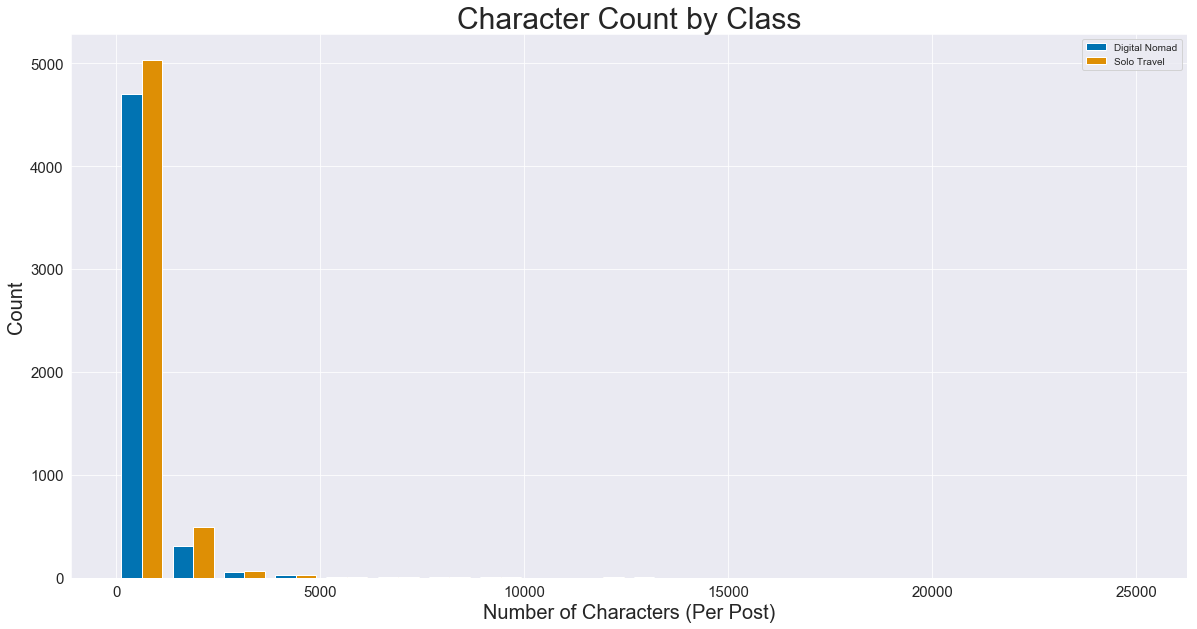

In [43]:
plt.figure(figsize=(20, 10))
plt.hist([combined_df[combined_df['digital_nomad'] == 1]['char_count'],
         combined_df[combined_df['digital_nomad'] == 0]['char_count']],
         bins=20)
plt.title('Character Count by Class', fontsize=30)
plt.xlabel('Number of Characters (Per Post)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Digital Nomad', 'Solo Travel']);

-  Most posts contain less than 5000 characters for both subreddits.
-  r/solotravel has a greater count than r/digitalnomad, but there doesn't appear to be a significant difference to help us determine which subreddit a given post belongs in.

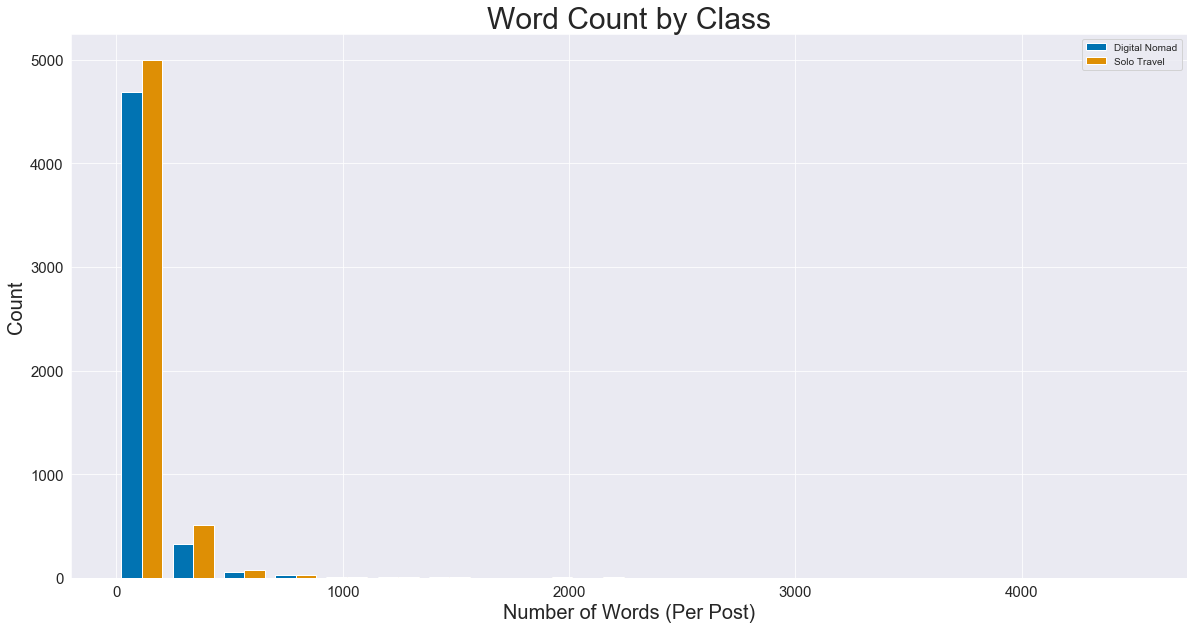

In [44]:
plt.figure(figsize=(20, 10))
plt.hist([combined_df[combined_df['digital_nomad'] == 1]['word_count'],
         combined_df[combined_df['digital_nomad'] == 0]['word_count']],
         bins=20)
plt.title('Word Count by Class', fontsize=30)
plt.xlabel('Number of Words (Per Post)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Digital Nomad', 'Solo Travel']);

-  Most posts have less than 1000 words for both subreddits.
-  Again, r/solotravel has a greater count than r/digitalnomad, but there isn't a significant difference to provide any insight. 

From the bar chart, we can see that there's a word count of 1. Given that posts with only 1 word will typically not relay much information or mainly consists of pictures, we'll remove them. 

In [45]:
combined_df[combined_df['word_count'] <= 1].head()

,title,selftext,text,digital_nomad,word_count,char_count
97,moana,,moana,1,1,6
564,dig,,dig,1,1,4
664,https://­get.cryptobrowser.sit­e/842991,,,1,0,2
735,SPANISH,,SPANISH,1,1,8
1448,Santorini,,Santorini,1,1,10


In [46]:
combined_df.drop(labels=combined_df[combined_df['word_count'] <= 1].index, inplace=True)

In [47]:
combined_df.reset_index(drop=True, inplace=True)

### Most Common Words

We want to use CountVectorizer() to visualize the most commonly used words and their frequency to see if there are any obvious differences we can identify immediately. Before doing so, we must tokenize, remove stop words and lemmatize our `text`. 

#### Tokenize

We instantiate tokenizer and define the search pattern using `r'\w+` as our regular expression. We only want to search through words and omit digits and symbols since they cannot serve as keywords in our digital network campaign.

In [48]:
tokenizer = RegexpTokenizer(r'\w+')

We tokenize the `text` column and create a new column (`text_tokenized`) for our results.

In [49]:
combined_df['text_tokenized'] = [tokenizer.tokenize(combined_df['text'][i]) for i in range(len(combined_df))]

In [50]:
combined_df.head()

,title,selftext,text,digital_nomad,word_count,char_count,text_tokenized
0,Where to spend the next month in the USA -,I need to burn a month until mid-January. I ca...,Where to spend the next month in the USA - I n...,1,65,317,"[Where, to, spend, the, next, month, in, the, ..."
1,Apologies if this is old news,https://tulsaremote.com/,Apologies if this is old news,1,6,31,"[Apologies, if, this, is, old, news]"
2,Where to look for cheap flights around Europe?,I've always heard of people getting £10 flight...,Where to look for cheap flights around Europe?...,1,48,257,"[Where, to, look, for, cheap, flights, around,..."
3,Social media training,Hi all! I am a digital marketing professional ...,Social media training Hi all! I am a marketi...,1,43,265,"[Social, media, training, Hi, all, I, am, a, m..."
4,Suggestions for place to live in US? (Preferab...,I'm starting my first remote job in January an...,Suggestions for place to live in US? (Preferab...,1,53,309,"[Suggestions, for, place, to, live, in, US, Pr..."


#### Remove Stop Words

We want to remove stop words because they are commonly used and will only contribute noise to our model. In addition to the default english stop words, we've added words that appear with high frequency but contains no legitimate information about the post.

In [51]:
def remove_stop_words(df, col):
    no_stop_words = []
    stops = set(stop_words.ENGLISH_STOP_WORDS)
    more_stops = set(['just', 've', 'don', 'wa', 'ing', 'll', 'the'])
    for i in range(len(df[col])):
        no_stops = [word for word in df[col][i] if not word in stops]
        meaningful_words = [word for word in no_stops if not word in more_stops]
        no_stop_words.append(meaningful_words)
    return no_stop_words

The remaining words are saved in the `text_meaningful` column.

In [52]:
combined_df['text_meaningful'] = remove_stop_words(combined_df, 'text_tokenized')

#### Lemmatize

Before CountVectorizer(), we want to combine similar forms of the same word. We will lemmatize our data in an attempt to return the base form of each word.

Instantiate lemmatizer

In [53]:
lemmatizer = WordNetLemmatizer()

We lemmatize the tokenized, meaningful words in `text_meaningful` and join them to represent one string again. This is shown in the `text_lemmatized` column.

In [54]:
combined_df['text_lemmatized'] = combined_df['text_meaningful'].map(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

In [55]:
combined_df.head()

,title,selftext,text,digital_nomad,word_count,char_count,text_tokenized,text_meaningful,text_lemmatized
0,Where to spend the next month in the USA -,I need to burn a month until mid-January. I ca...,Where to spend the next month in the USA - I n...,1,65,317,"[Where, to, spend, the, next, month, in, the, ...","[Where, spend, month, USA, I, need, burn, mont...",Where spend month USA I need burn month mid Ja...
1,Apologies if this is old news,https://tulsaremote.com/,Apologies if this is old news,1,6,31,"[Apologies, if, this, is, old, news]","[Apologies, old, news]",Apologies old news
2,Where to look for cheap flights around Europe?,I've always heard of people getting £10 flight...,Where to look for cheap flights around Europe?...,1,48,257,"[Where, to, look, for, cheap, flights, around,...","[Where, look, cheap, flights, Europe, I, heard...",Where look cheap flight Europe I heard people ...
3,Social media training,Hi all! I am a digital marketing professional ...,Social media training Hi all! I am a marketi...,1,43,265,"[Social, media, training, Hi, all, I, am, a, m...","[Social, media, training, Hi, I, marketing, pr...",Social medium training Hi I marketing professi...
4,Suggestions for place to live in US? (Preferab...,I'm starting my first remote job in January an...,Suggestions for place to live in US? (Preferab...,1,53,309,"[Suggestions, for, place, to, live, in, US, Pr...","[Suggestions, place, live, US, Preferably, sem...",Suggestions place live US Preferably semi urba...


#### Count Vectorize

With the `text_lemmatized` column, we're ready to visualize the frequency of words in the posts. 

We instantiate CountVectorizer() and set:
-  `min_df=.03`: ignore terms that have a document frequency lower than 3%. We do not want to include terms that occur in less than 3% of the documents because they can simply be common typos.
-  `max_df=.95`: ignore terms that have a document frequency greater than 95%. We do not want to include terms that occur in almost all documents because they're likely to occur in both subreddits and will not help categorize a given post in one or the other community. 

We create a dataframe with all the words in our corpus and their count.

In [56]:
vect = CountVectorizer(min_df=.03, max_df=.95)
X = vect.fit_transform(combined_df['text_lemmatized'])
text = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

In order to determine the subreddit in which a document belongs in, we set the `digital_nomad` column from our combined dataframe as the index.

In [57]:
text.index = combined_df['digital_nomad']

In [58]:
text.head()

,able,abroad,actually,advance,advice,ago,airbnb,also,america,and,...,what,where,wondering,work,working,world,worth,would,year,you
digital_nomad,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### **Digital Nomad Word Count**

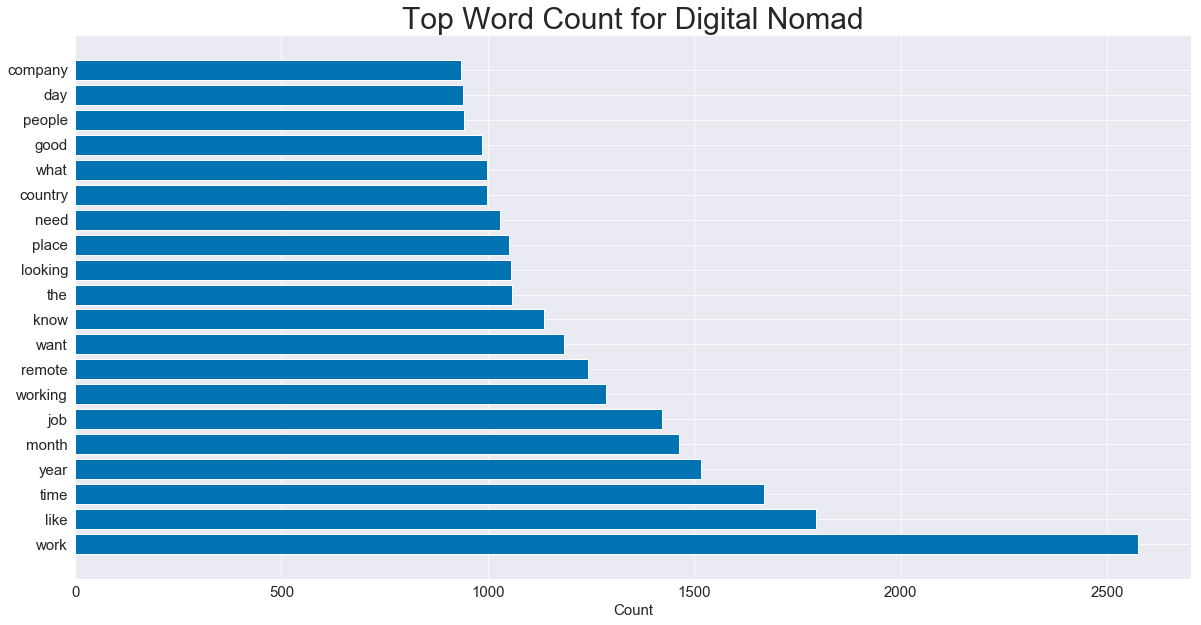

In [59]:
plt.figure(figsize=(20, 10))
plt.barh(y = text[text.index == 1].sum().sort_values(ascending=False).head(20).index,
         width = text[text.index == 1].sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count for Digital Nomad', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

-  For r/digitalnomad, most of the top 20 words are either associated with work (`work`, `remote`, `company`) or indicates long-term plans (`year`, `month`). This aligns with what we think a digital nomad will consistenly talk about: 
    -  working remotely 
    -  lifestyle (something that's long-term rather than short-term)
-  Words like `want`, `know`, `looking`, `need` can indicate users are using this community to both share and seek advice.

##### **Solo Travel Word Count**

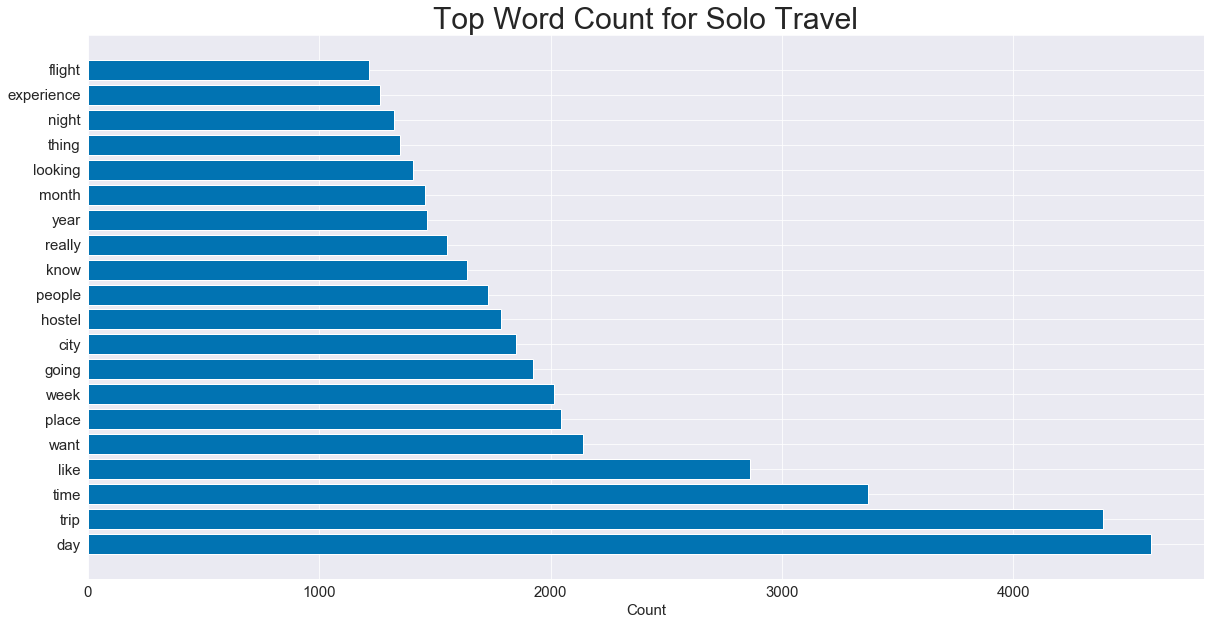

In [60]:
plt.figure(figsize=(20, 10))
plt.barh(y = text[text.index == 0].sum().sort_values(ascending=False).head(20).index,
         width = text[text.index == 0].sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count for Solo Travel', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

-  For r/solotravel, most of the top 20 words indicate temporary plans.
-  Words like `trip`, `week`, `hostel`, and `time` indicate users are posting about short-term trips. It's unlikely for a digital nomad to use words like these since they'll be looking for more permanent living situations. 

**Similarities:**
-  The following words occur frequently in both subreddits:
    -  like
    -  day
    -  time
    -  looking
    -  know
    -  want
    -  place
    -  people
    -  year
    -  month
-  Many of the words indicate both subreddits are used to share experiences and seek information. 

**Differences:**
-  Even though the two subreddits share several frequently occuring words, the frequency within each still differs.
-  `year` and `month` occurs more frequently in r/digitalnomad. 
-  On the other hand, `day` occurs the most frequently in r/solotravel compared to the 19th most frequent word in r/digitalnomad.
-  `trip` is the second most frequent word in r/solotravel, yet it never occurs in r/digitalnomad. Given that digital nomads reside in a location for a longer period of time, it's unlikely for them to refer to it as a trip.
-  `work` and `working` never occurs in r/solotravel, but is repeatedly seen in r/digitalnomad. Solo travelers are more likely to be to traveling for leisure and will not be mentioning anything work-related in the posts.

## Save as CSV

In [61]:
combined_df.to_csv('../data/all_posts.csv')

In [62]:
text.to_csv('../data/countvect.csv')